In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE = '/content/drive/MyDrive/the-future-crop-challenge'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on", device)

Running on cuda


In [6]:
# 1) Mount & imports

import os
import pandas as pd

# 3) List all the maize‐train parquet files
all_files = sorted(fn
                   for fn in os.listdir(BASE)
                   if fn.endswith('_maize_train.parquet'))
print("Found maize‐train files:\n", all_files)

# 4) Load yields (train_solutions) and reset ID from index → column
yld = pd.read_parquet(os.path.join(BASE, 'train_solutions_maize.parquet'))
if yld.index.name == 'ID':
    yld = yld.reset_index()
print("Yields columns:", yld.columns.tolist())

# 5) Load soil+CO₂ and reset ID
soil_fn = [f for f in all_files if f.startswith('soil_co2')][0]
soil   = pd.read_parquet(os.path.join(BASE, soil_fn))
if soil.index.name == 'ID':
    soil = soil.reset_index()
print("Soil columns:", soil.columns.tolist())

# 6) Merge yields + soil on ID
data = yld.merge(
    soil[['ID','real_year','texture_class','nitrogen','co2']],
    on='ID', how='left'
)
print("After soil merge:", data.shape)

# 7) Pick out just the climate files (pr, rsds, tas, tasmax, tasmin)
climate_files = [f for f in all_files
                 if f.split('_')[0] in {'pr','rsds','tas','tasmax','tasmin'}]
print("Will merge these climate files:\n", climate_files)

# 8) Loop & merge, renaming day‑cols to <var>_<day> so there are no dupes
for fn in climate_files:
    var = fn.split('_')[0]                 # 'pr' or 'rsds' or 'tas'/'tasmax'/'tasmin'
    df  = pd.read_parquet(os.path.join(BASE, fn))
    if df.index.name == 'ID':
        df = df.reset_index()

    # day‑columns are named '0','1',…'239'
    day_cols = [c for c in df.columns if c.isdigit()]
    # build rename map so pr‑days become pr_0, pr_1, … etc.
    rename_map = {c: f"{var}_{c}" for c in day_cols}

    # slice out ID + day‑cols, rename, and merge
    df_days = df[['ID'] + day_cols].rename(columns=rename_map)
    print(f"Merging {fn!r}: {len(day_cols)} days → new cols prefix '{var}_'")
    data = data.merge(df_days, on='ID', how='left')

# 9) Check final size
print("Final data shape:", data.shape)
print("Sample of all columns:", data.columns[:12].tolist(), "…")


Found maize‐train files:
 ['pr_maize_train.parquet', 'rsds_maize_train.parquet', 'soil_co2_maize_train.parquet', 'tas_maize_train.parquet', 'tasmax_maize_train.parquet', 'tasmin_maize_train.parquet']
Yields columns: ['ID', 'yield']
Soil columns: ['ID', 'crop', 'year', 'lon', 'lat', 'texture_class', 'real_year', 'co2', 'nitrogen']
After soil merge: (349719, 6)
Will merge these climate files:
 ['pr_maize_train.parquet', 'rsds_maize_train.parquet', 'tas_maize_train.parquet', 'tasmax_maize_train.parquet', 'tasmin_maize_train.parquet']
Merging 'pr_maize_train.parquet': 240 days → new cols prefix 'pr_'
Merging 'rsds_maize_train.parquet': 240 days → new cols prefix 'rsds_'
Merging 'tas_maize_train.parquet': 240 days → new cols prefix 'tas_'
Merging 'tasmax_maize_train.parquet': 240 days → new cols prefix 'tasmax_'
Merging 'tasmin_maize_train.parquet': 240 days → new cols prefix 'tasmin_'
Final data shape: (349719, 1206)
Sample of all columns: ['ID', 'yield', 'real_year', 'texture_class', 'nit

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

# 1) Train/validation split by real_year
train_df = data[data.real_year < 2020].reset_index(drop=True)
val_df   = data[data.real_year == 2020].reset_index(drop=True)

# 2) Extract target arrays
y_train = train_df['yield'].values.astype(np.float32)
y_val   = val_df  ['yield'].values.astype(np.float32)

# 3) Build dynamic (time‑series) feature arrays
clim_vars = ['pr', 'rsds', 'tas', 'tasmax', 'tasmin']
dyn_cols = []
for var in clim_vars:
    dyn_cols += [c for c in train_df.columns if c.startswith(f"{var}_")]

X_train_dyn = train_df[dyn_cols].values.astype(np.float32)
X_val_dyn   = val_df  [dyn_cols].values.astype(np.float32)

# 4) Scale and reshape dynamic features → (samples, 240, 5)
scaler_dyn   = StandardScaler()
X_train_dyn  = scaler_dyn.fit_transform(X_train_dyn)
X_val_dyn    = scaler_dyn.transform(X_val_dyn)
X_train_dyn  = X_train_dyn.reshape(-1, 240, len(clim_vars))
X_val_dyn    = X_val_dyn.reshape(-1, 240, len(clim_vars))

# 5) Build static feature arrays and scale → (samples, 3)
stat_cols   = ['texture_class', 'nitrogen', 'co2']
X_train_stat = train_df[stat_cols].values.astype(np.float32)
X_val_stat   = val_df  [stat_cols].values.astype(np.float32)

scaler_stat  = StandardScaler()
X_train_stat = scaler_stat.fit_transform(X_train_stat)
X_val_stat   = scaler_stat.transform(X_val_stat)

# 6) Define a PyTorch Dataset
class CropDataset(Dataset):
    def __init__(self, Xdyn, Xstat, y):
        self.Xdyn  = torch.from_numpy(Xdyn)
        self.Xstat = torch.from_numpy(Xstat)
        self.y     = torch.from_numpy(y).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.Xdyn[idx], self.Xstat[idx], self.y[idx]

# 7) Instantiate datasets and dataloaders
train_ds = CropDataset(X_train_dyn, X_train_stat, y_train)
val_ds   = CropDataset(X_val_dyn,   X_val_stat,   y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

# Quick sanity check
print("Train batches:", len(train_loader),
      "| Val batches:", len(val_loader))

Train batches: 10646 | Val batches: 284


In [8]:
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch.optim import Adam

# 1) Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 2) Model definition
class CropLSTM(nn.Module):
    def __init__(self, n_dyn_feats=5, seq_len=240, n_stat=3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_dyn_feats, hidden_size=64,
                            batch_first=True)
        self.dyn_fc = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.stat_fc = nn.Sequential(nn.Linear(n_stat, 16), nn.ReLU())
        self.head = nn.Sequential(
            nn.Linear(32 + 16, 16), nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x_dyn, x_stat):
        _, (h_n, _) = self.lstm(x_dyn)      # (1, B, 64)
        h = h_n.squeeze(0)                  # → (B, 64)
        d = self.dyn_fc(h)                  # → (B, 32)
        s = self.stat_fc(x_stat)            # → (B, 16)
        return self.head(torch.cat([d, s], dim=1))

model = CropLSTM(n_dyn_feats=len(clim_vars), n_stat=len(stat_cols)).to(device)

# 3) Loss & optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# 4) Training loop with tqdm & R²
best_val_loss = float('inf')
patience, wait = 5, 0

for epoch in range(1, 51):
    # —— Train ——
    model.train()
    train_losses, train_preds, train_trues = [], [], []
    for Xd, Xs, y in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        Xd, Xs, y = Xd.to(device), Xs.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(Xd, Xs)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item() * y.size(0))
        train_preds.append(out.detach().cpu())
        train_trues.append(y.cpu())

    train_mse = sum(train_losses) / len(train_loader.dataset)
    train_r2  = r2_score(
        torch.cat(train_trues).numpy(),
        torch.cat(train_preds).numpy()
    )

    # —— Validate ——
    model.eval()
    val_losses, val_preds, val_trues = [], [], []
    for Xd, Xs, y in tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False):
        Xd, Xs, y = Xd.to(device), Xs.to(device), y.to(device)
        out = model(Xd, Xs)
        val_losses.append(criterion(out, y).item() * y.size(0))
        val_preds.append(out.detach().cpu())
        val_trues.append(y.cpu())

    val_mse = sum(val_losses) / len(val_loader.dataset)
    val_r2  = r2_score(
        torch.cat(val_trues).numpy(),
        torch.cat(val_preds).numpy()
    )

    print(f"Epoch {epoch:02d} | "
          f"Train MSE={train_mse:.4f} | Train R²={train_r2:.4f} | "
          f"Val MSE={val_mse:.4f} | Val R²={val_r2:.4f}")

    # Early stopping
    if val_mse < best_val_loss:
        best_val_loss, wait = val_mse, 0
        torch.save(model.state_dict(), 'best_crop_lstm.pth')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# 5) Final 2020 evaluation
model.load_state_dict(torch.load('best_crop_lstm.pth'))
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for Xd, Xs, y in val_loader:
        Xd, Xs, y = Xd.to(device), Xs.to(device), y.to(device)
        out = model(Xd, Xs)
        all_preds.append(out.cpu())
        all_trues.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_trues = torch.cat(all_trues).numpy()
final_mse = ((all_preds - all_trues)**2).mean()
final_r2  = r2_score(all_trues, all_preds)

print(f"\nFinal 2020 RMSE: {final_mse**0.5:.4f} | Final 2020 R²: {final_r2:.4f}")

Using device: cuda


Epoch 1 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 01 | Train MSE=3.5718 | Train R²=0.5289 | Val MSE=2.2306 | Val R²=0.6321


Epoch 2 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 02 | Train MSE=2.3117 | Train R²=0.6951 | Val MSE=2.1711 | Val R²=0.6419


Epoch 3 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 03 | Train MSE=1.8819 | Train R²=0.7518 | Val MSE=1.5704 | Val R²=0.7410


Epoch 4 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 04 | Train MSE=1.6823 | Train R²=0.7781 | Val MSE=1.5059 | Val R²=0.7516


Epoch 5 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 05 | Train MSE=1.5575 | Train R²=0.7946 | Val MSE=1.6299 | Val R²=0.7312


Epoch 6 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 06 | Train MSE=1.4785 | Train R²=0.8050 | Val MSE=1.4985 | Val R²=0.7529


Epoch 7 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 07 | Train MSE=1.4105 | Train R²=0.8140 | Val MSE=1.4207 | Val R²=0.7657


Epoch 8 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 08 | Train MSE=1.3608 | Train R²=0.8205 | Val MSE=1.5815 | Val R²=0.7392


Epoch 9 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 09 | Train MSE=1.3156 | Train R²=0.8265 | Val MSE=1.4889 | Val R²=0.7544


Epoch 10 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 10 | Train MSE=1.2788 | Train R²=0.8313 | Val MSE=1.4220 | Val R²=0.7655


Epoch 11 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 11 | Train MSE=1.2474 | Train R²=0.8355 | Val MSE=1.5580 | Val R²=0.7430


Epoch 12 Training:   0%|          | 0/10646 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/284 [00:00<?, ?it/s]

Epoch 12 | Train MSE=1.2187 | Train R²=0.8393 | Val MSE=1.5336 | Val R²=0.7471
Early stopping triggered.

Final 2020 RMSE: 1.1919 | Final 2020 R²: 0.7657


## Baseline MSE of Predicting Mean of Maize

In [9]:
import numpy as np

y = train_df['yield'].values
baseline_mse  = np.var(y)                   # MSE of always‑predicting y.mean()
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline RMSE = {baseline_rmse:.3f}, MSE = {baseline_mse:.3f}")

Baseline RMSE = 2.754, MSE = 7.582


## Wheat Yield Prediction

In [10]:
from google.colab import drive
import os, pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader


# 2) Set crop type
crop = 'wheat'

# 3) Discover available wheat‐train files
all_files = sorted(fn for fn in os.listdir(BASE) if fn.endswith(f'_{crop}_train.parquet'))
print("Available wheat‐train files:", all_files)

# 4) Load yields & reset index
yld = pd.read_parquet(os.path.join(BASE, f'train_solutions_{crop}.parquet'))
if yld.index.name == 'ID':
    yld = yld.reset_index()
print("Yields columns:", yld.columns.tolist())

# 5) Load soil/CO₂ & reset index
soil = pd.read_parquet(os.path.join(BASE, f'soil_co2_{crop}_train.parquet'))
if soil.index.name == 'ID':
    soil = soil.reset_index()
print("Soil columns:", soil.columns.tolist())

# 6) Merge yields + soil
data = yld.merge(
    soil[['ID','real_year','texture_class','nitrogen','co2']],
    on='ID', how='left'
)
print("After soil merge:", data.shape)

# 7) Merge each climate series (pr, rsds, tas, tasmax, tasmin)
clim_vars = ['pr','rsds','tas','tasmax','tasmin']
for var in clim_vars:
    fn = f"{var}_{crop}_train.parquet"
    df = pd.read_parquet(os.path.join(BASE, fn))
    if df.index.name == 'ID':
        df = df.reset_index()
    day_cols = [c for c in df.columns if c.isdigit()]
    # rename '0'→'pr_0', etc.
    rename_map = {c: f"{var}_{c}" for c in day_cols}
    df_days = df[['ID'] + day_cols].rename(columns=rename_map)
    data = data.merge(df_days, on='ID', how='left')
    print(f"Merged {fn} → now data shape {data.shape}")

# 8) Train/val split by real_year
train_df = data[data.real_year < 2020].reset_index(drop=True)
val_df   = data[data.real_year == 2020].reset_index(drop=True)

# 9) Targets
y_train = train_df['yield'].values.astype(np.float32)
y_val   = val_df  ['yield'].values.astype(np.float32)

# 10) Dynamic ("time‑series") features
dyn_cols = [c for var in clim_vars for c in train_df.columns if c.startswith(f"{var}_")]
Xtr_dyn = train_df[dyn_cols].values.astype(np.float32)
Xvl_dyn = val_df  [dyn_cols].values.astype(np.float32)

scaler_dyn = StandardScaler()
Xtr_dyn = scaler_dyn.fit_transform(Xtr_dyn).reshape(-1, 240, len(clim_vars))
Xvl_dyn = scaler_dyn.transform(Xvl_dyn).reshape(-1, 240, len(clim_vars))

# 11) Static features
stat_cols = ['texture_class','nitrogen','co2']
Xtr_stat  = train_df[stat_cols].values.astype(np.float32)
Xvl_stat  = val_df  [stat_cols].values.astype(np.float32)

scaler_stat = StandardScaler()
Xtr_stat = scaler_stat.fit_transform(Xtr_stat)
Xvl_stat = scaler_stat.transform(Xvl_stat)

# 12) PyTorch Dataset & DataLoader
class WheatDataset(Dataset):
    def __init__(self, Xdyn, Xstat, y):
        self.Xdyn  = torch.from_numpy(Xdyn)
        self.Xstat = torch.from_numpy(Xstat)
        self.y     = torch.from_numpy(y).unsqueeze(1)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.Xdyn[idx], self.Xstat[idx], self.y[idx]

train_ds = WheatDataset(Xtr_dyn, Xtr_stat, y_train)
val_ds   = WheatDataset(Xvl_dyn, Xvl_stat, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)

print("Wheat train batches:", len(train_loader), "| Wheat val batches:", len(val_loader))

Available wheat‐train files: ['pr_wheat_train.parquet', 'rsds_wheat_train.parquet', 'soil_co2_wheat_train.parquet', 'tas_wheat_train.parquet', 'tasmax_wheat_train.parquet', 'tasmin_wheat_train.parquet']
Yields columns: ['ID', 'yield']
Soil columns: ['ID', 'crop', 'year', 'lon', 'lat', 'texture_class', 'real_year', 'co2', 'nitrogen']
After soil merge: (278747, 6)
Merged pr_wheat_train.parquet → now data shape (278747, 246)
Merged rsds_wheat_train.parquet → now data shape (278747, 486)
Merged tas_wheat_train.parquet → now data shape (278747, 726)
Merged tasmax_wheat_train.parquet → now data shape (278747, 966)
Merged tasmin_wheat_train.parquet → now data shape (278747, 1206)
Wheat train batches: 8487 | Wheat val batches: 225


In [11]:
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm.auto import tqdm
from sklearn.metrics import r2_score

# ——— 1) Device ———
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ——— 2) Model ———
# Re‑use the CropLSTM class you defined earlier
model = CropLSTM(n_dyn_feats=len(clim_vars), n_stat=len(stat_cols)).to(device)

# ——— 3) Loss & Optimizer ———
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# ——— 4) Training loop with early stopping & R² ———
best_val_loss = float('inf')
patience, wait = 5, 0

for epoch in range(1, 51):
    # — Train —
    model.train()
    train_losses, train_preds, train_trues = [], [], []
    for Xd, Xs, y in tqdm(train_loader, desc=f"Epoch {epoch} Train", leave=False):
        Xd, Xs, y = Xd.to(device), Xs.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(Xd, Xs)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item() * y.size(0))
        train_preds.append(out.detach().cpu())
        train_trues.append(y.cpu())

    train_mse = sum(train_losses) / len(train_loader.dataset)
    train_r2  = r2_score(
        torch.cat(train_trues).numpy(),
        torch.cat(train_preds).numpy()
    )

    # — Validate —
    model.eval()
    val_losses, val_preds, val_trues = [], [], []
    for Xd, Xs, y in tqdm(val_loader, desc=f"Epoch {epoch} Val", leave=False):
        Xd, Xs, y = Xd.to(device), Xs.to(device), y.to(device)
        out = model(Xd, Xs)
        val_losses.append(criterion(out, y).item() * y.size(0))
        val_preds.append(out.detach().cpu())
        val_trues.append(y.cpu())

    val_mse = sum(val_losses) / len(val_loader.dataset)
    val_r2  = r2_score(
        torch.cat(val_trues).numpy(),
        torch.cat(val_preds).numpy()
    )

    print(
        f"Epoch {epoch:02d} | "
        f"Train MSE={train_mse:.4f} | Train R²={train_r2:.4f} | "
        f"Val MSE={val_mse:.4f} | Val R²={val_r2:.4f}"
    )

    # — Early stopping —
    if val_mse < best_val_loss:
        best_val_loss, wait = val_mse, 0
        torch.save(model.state_dict(), 'best_wheat_lstm.pth')
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# ——— 5) Final hold‑out evaluation on 2020 ———
model.load_state_dict(torch.load('best_wheat_lstm.pth'))
model.eval()

all_preds, all_trues = [], []
with torch.no_grad():
    for Xd, Xs, y in val_loader:
        Xd, Xs, y = Xd.to(device), Xs.to(device), y.to(device)
        out = model(Xd, Xs)
        all_preds.append(out.cpu())
        all_trues.append(y.cpu())

all_preds = torch.cat(all_preds).numpy().ravel()
all_trues = torch.cat(all_trues).numpy().ravel()

final_mse = ((all_preds - all_trues)**2).mean()
final_r2  = r2_score(all_trues, all_preds)

print(f"\nFinal 2020 RMSE: {final_mse**0.5:.4f} | Final 2020 R²: {final_r2:.4f}")

Using device: cuda


Epoch 1 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 01 | Train MSE=1.5483 | Train R²=0.5736 | Val MSE=1.2566 | Val R²=0.6176


Epoch 2 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 02 | Train MSE=1.1001 | Train R²=0.6970 | Val MSE=1.0181 | Val R²=0.6902


Epoch 3 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 03 | Train MSE=0.9992 | Train R²=0.7248 | Val MSE=0.9570 | Val R²=0.7088


Epoch 4 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 04 | Train MSE=0.9440 | Train R²=0.7400 | Val MSE=0.9557 | Val R²=0.7091


Epoch 5 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 05 | Train MSE=0.9040 | Train R²=0.7510 | Val MSE=0.9291 | Val R²=0.7172


Epoch 6 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 06 | Train MSE=0.8705 | Train R²=0.7603 | Val MSE=0.9702 | Val R²=0.7047


Epoch 7 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 07 | Train MSE=0.8428 | Train R²=0.7679 | Val MSE=1.0325 | Val R²=0.6858


Epoch 8 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 08 | Train MSE=0.8176 | Train R²=0.7749 | Val MSE=0.9520 | Val R²=0.7103


Epoch 9 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 09 | Train MSE=0.7937 | Train R²=0.7814 | Val MSE=0.9423 | Val R²=0.7132


Epoch 10 Train:   0%|          | 0/8487 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 | Train MSE=0.7751 | Train R²=0.7866 | Val MSE=0.9437 | Val R²=0.7128
Early stopping triggered.

Final 2020 RMSE: 0.9639 | Final 2020 R²: 0.7172


In [12]:
import numpy as np

# 1) Obtain training yields
y_train = train_df['yield'].values.astype(np.float32)

# 2) Compute baseline MSE & RMSE (predicting the training mean)
baseline_mse  = np.var(y_train)
baseline_rmse = np.sqrt(baseline_mse)

# 3) Print
print(f"Baseline MSE (wheat)  = {baseline_mse:.4f}")
print(f"Baseline RMSE (wheat) = {baseline_rmse:.4f}")

Baseline MSE (wheat)  = 3.6312
Baseline RMSE (wheat) = 1.9056


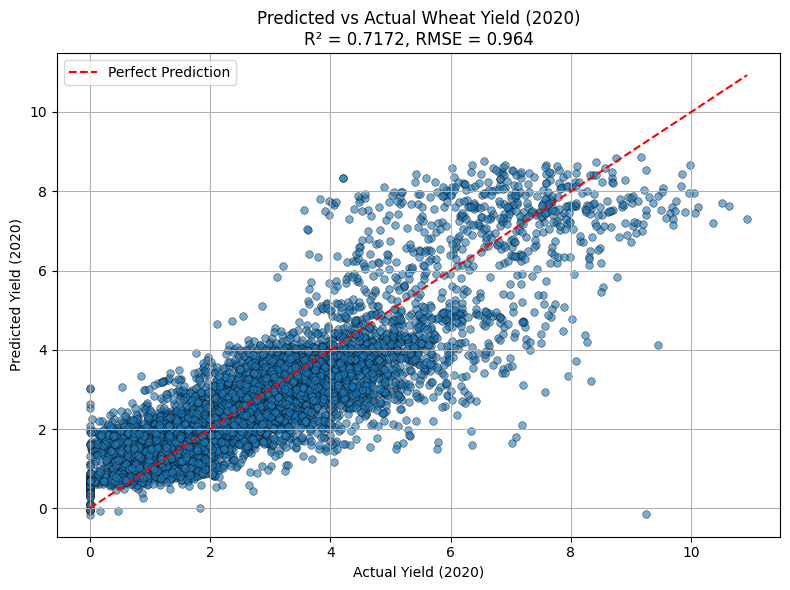

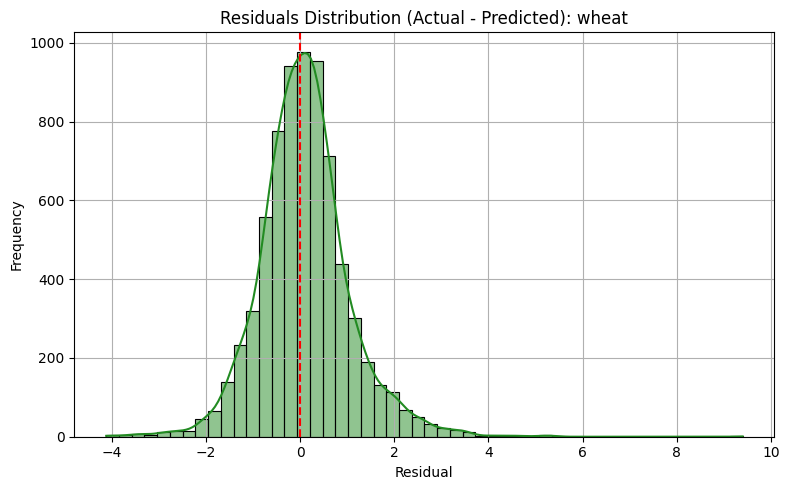

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predicted vs Actual Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=all_trues, y=all_preds, alpha=0.6, edgecolor='k', s=30)
plt.plot([all_trues.min(), all_trues.max()],
         [all_trues.min(), all_trues.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield (2020)")
plt.ylabel("Predicted Yield (2020)")
plt.title(f"Predicted vs Actual Wheat Yield (2020)\nR² = {final_r2:.4f}, RMSE = {final_mse**0.5:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residuals Histogram
residuals = all_trues - all_preds
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True, color='forestgreen')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution (Actual - Predicted): wheat")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()


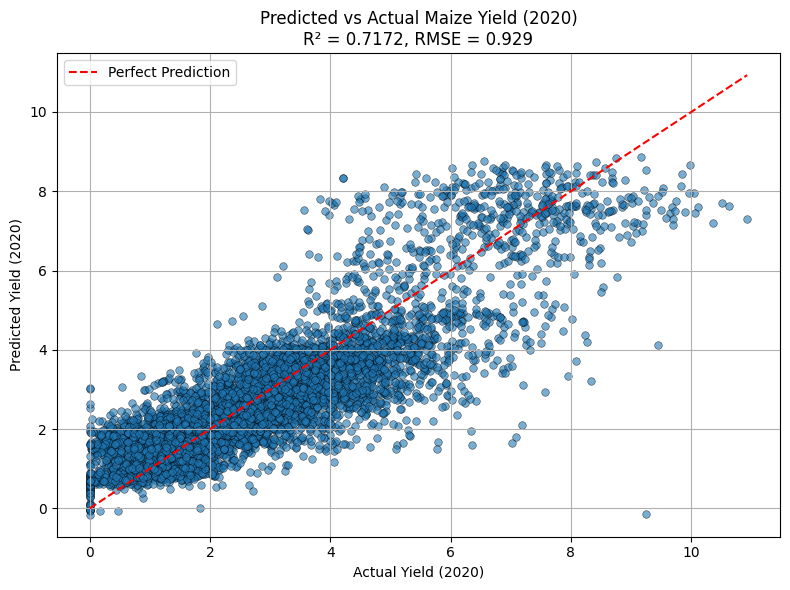

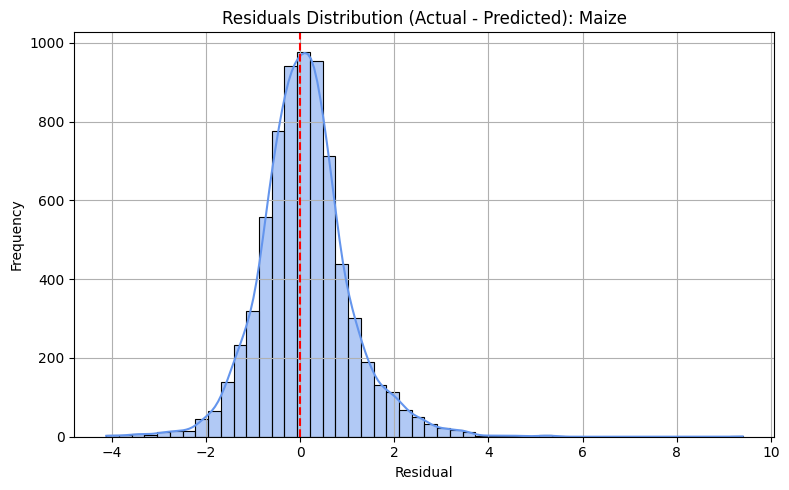

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error


maize_preds = all_preds.copy()
maize_trues = all_trues.copy()

# Compute R² and RMSE
final_r2_maize = r2_score(maize_trues, maize_preds)
final_rmse_maize = mean_squared_error(maize_trues, maize_preds)

# 1. Predicted vs Actual Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=maize_trues, y=maize_preds, alpha=0.6, edgecolor='k', s=30)
plt.plot([maize_trues.min(), maize_trues.max()],
         [maize_trues.min(), maize_trues.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield (2020)")
plt.ylabel("Predicted Yield (2020)")
plt.title(f"Predicted vs Actual Maize Yield (2020)\nR² = {final_r2_maize:.4f}, RMSE = {final_rmse_maize:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Residuals Histogram
residuals_maize = maize_trues - maize_preds
plt.figure(figsize=(8, 5))
sns.histplot(residuals_maize, bins=50, kde=True, color='cornflowerblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Residuals Distribution (Actual - Predicted): Maize")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()
